# Applying otimal LDA model on sentences of reviews

Goal: Finding the best topic modeling model with optimum value of number of topics 'k', to generate most optimal topics on reviews

In [77]:
#Importing Libraries
import gensim
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from stop_words import get_stop_words
from gensim import corpora, models
from gensim.models import Phrases
from nltk.stem.porter import *
import numpy as np
import operator
import nltk
# Compute bigrams.
from gensim.models import Phrases
from pprint import pprint
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

In [91]:
import pickle

In [1]:
import pandas as pd

In [11]:
#Loading data. This data is obtained by grouping the product IDs with respect number reviews and merging their reviews together.
df = pd.read_csv('/Users/harika_pradeep/Downloads/df_grouped.csv', index_col=0)

In [5]:
#Loading metadata that has product titles for each product.
df_m = pd.read_csv('/Users/harika_pradeep/Downloads/Title_prod.csv', index_col=0)

/Users/harika_pradeep/miniconda3/envs/tensorflow/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df.shape

(188138, 2)

In [6]:
df_m.shape

(1301225, 2)

In [7]:
df.head()

,reviewText,count
asin,,
B00FLYWNYQ,I was excited to try this so as soon as I got ...,7433
B00COK3FD8,The tupperware was exactly as described. I lov...,4563
B009HVH4XO,i have 4 of these and i didn't think they coul...,4460
B00NX47YP4,Pros:\nSeems to weigh accurately\nEasy to use ...,4379
B00902X68W,I love these sheets. They are so soft and coz...,3725


In [8]:
df_m.head()

,asin,title
0,0001487795,You Are Special Today Red Plate [With Red Pen]
1,0002020300,Vicks Inhaler Relief for Cold Sinus Nasal Cong...
2,0006564224,Artistic Churchware Communion Cup Filler: RW525
3,0009046461,4 BARS! Mysore Sandal Soap 70grams FAST SHIPPING
4,0234937912,AROGYA VATI (40gm) by popeye seller


In [51]:
#Merging both the dataframes with product ID column "asin"
df_merged = pd.merge (df_m,df,left_on='asin',right_on='asin')

In [52]:
df_merged.shape 

(192603, 4)

In [53]:
df_merged[df_merged['title'].isnull()].shape

(2, 4)

In [54]:
df_m['asin'].unique().shape[0]

1286077

In [55]:
df_merged.head()

,asin,title,reviewText,count
0,0560467893,"WELLAND Chicago Wall Floating Corner Shelf, 20...","Pretty flimsy, but does the job. If your corne...",5
1,0681795107,Stainless Coffee Mug,I love this mug. It cleans easily and keeps dr...,14
2,0768205921,Judy Instructo My Own Little Judy Clock with B...,This is a great learning tool for teaching chi...,11
3,0805469613,"Communion Cups-Plastic, 500ct","Great cups for communion, just wished I would ...",6
4,0983124248,My Sticker Book: Princess Swing – Reusable Sti...,"Very cool sticker book. You can stick, remove,...",5


In [56]:
# Sorting the rows in decreasing order
df_merged.sort_values(by=['count'],inplace=True,ascending=False)

In [57]:
df_merged.head ()

,asin,title,reviewText,count
98366,B00FLYWNYQ,Instant Pot DUO60 6 Qt 7-in-1 Multi-Use Progra...,I was excited to try this so as soon as I got ...,7433
87816,B00COK3FD8,Rubbermaid Easy Find Lids Food Storage Contain...,The tupperware was exactly as described. I lov...,4563
76075,B009HVH4XO,Contigo AUTOSEAL West Loop Vacuum-Insulated St...,i have 4 of these and i didn't think they coul...,4460
126926,B00NX47YP4,Ozeri ZK14-R Pronto Digital Multifunction Kitc...,Pros:\nSeems to weigh accurately\nEasy to use ...,4379
73536,B00902X68W,Clara Clark 1800 Premier Series 4pc Bed Sheet ...,I love these sheets. They are so soft and coz...,3725


In [58]:
df_merged.reset_index(drop = True, inplace = True)

In [66]:
df_merged.head ().shape

(5, 4)

In [112]:
#Considering only the top 25 products for further calculations (for memory constraints)
df_req = df_merged.head(25)

In [113]:
df_req.shape

(25, 4)

In [114]:
df_req

,asin,title,reviewText,count
0,B00FLYWNYQ,Instant Pot DUO60 6 Qt 7-in-1 Multi-Use Progra...,I was excited to try this so as soon as I got ...,7433
1,B00COK3FD8,Rubbermaid Easy Find Lids Food Storage Contain...,The tupperware was exactly as described. I lov...,4563
2,B009HVH4XO,Contigo AUTOSEAL West Loop Vacuum-Insulated St...,i have 4 of these and i didn't think they coul...,4460
3,B00NX47YP4,Ozeri ZK14-R Pronto Digital Multifunction Kitc...,Pros:\nSeems to weigh accurately\nEasy to use ...,4379
4,B00902X68W,Clara Clark 1800 Premier Series 4pc Bed Sheet ...,I love these sheets. They are so soft and coz...,3725
5,B00EINBSJ2,Coop Home Goods - PREMIUM Adjustable Loft - Sh...,"I received my pillow today. This pillow, alth...",3623
6,B009ZJ2M7G,Hoover Power Scrub Deluxe Carpet Washer FH50150,Same as another review only I got a single tan...,3290
7,B0091YYUAM,"BISSELL PowerFresh Steam Mop, Floor Steamer, T...","I wish I had something to compare this too, bu...",3272
8,B00JVLG2KG,"Thermos FUNtainer 12 Ounce Bottle, #All About Me",This thermos is the BEST! I have opened it an...,3264
9,B000YGEVMI,"Thermos FUNtainer 12 Ounce Bottle, #All About Me",***Update 9/26/2013 - We still have three of o...,3262


In [115]:
#splitting each review for these 25 products into sentences. This will be used while appying sentiment analysis on each sentence
df_req_copy = df_req
df_sentences = pd.DataFrame(df_req_copy.reviewText.str.split('.').tolist(), index=df_req_copy.asin).stack()
df_sentences =df_sentences.reset_index([0, 'asin'])
df_sentences.columns = ['asin', 'sentences']

In [116]:
#Total number of sentences on which we will be applying topic modeling and sentiment analysis is 300677
df_sentences.shape

(300677, 2)

In [117]:
df_sentences.head()

,asin,sentences
0,B00FLYWNYQ,I was excited to try this so as soon as I got ...
1,B00FLYWNYQ,I ended up with the best texture I've ever ha...
2,B00FLYWNYQ,"Plus the aroma stayed in the pot, so the rice..."
3,B00FLYWNYQ,This is the quietest rice cooker or pressure ...
4,B00FLYWNYQ,There was only quiet musical beeping when ope...


# Tokenization : Tokenizing each sentence into words

In [78]:
tokenizer = RegexpTokenizer(r'\w+')

In [79]:
#Applying this on one sentence
doc = df_sentences.sentences[0]

In [80]:
tokens = tokenizer.tokenize(doc.lower())
print('{} characters in string vs {} words in a list'.format(len(doc), len(tokens)))

162 characters in string vs 32 words in a list


In [81]:
docs = [token for token in tokens if not token.isnumeric()]
print('{} words in a list after removing numbers'.format(len(docs)))

32 words in a list after removing numbers


In [82]:
# Remove words that are less than 4 characters only
docs = [token for token in docs if len(token) > 3]
print('{} words in a list after words that are less than 4 chars'.format(len(docs)))

16 words in a list after words that are less than 4 chars


# Preparing stopwords and removing them

In [83]:
#create a merged list of stop words
nltk_stpwd = stopwords.words('english')
#Extend stopwords with commonly found tokens in review texts
nltk_stpwd.extend(['generally', 'used', 'personally', 'review', 'honestly','truly','whatever','done','star','one','two','three','four','five','since','ever','even','much','thing','also','go','come','must'])
stop_words_stpwd = get_stop_words('en')
merged_stopwords = list(set(nltk_stpwd + stop_words_stpwd))

print(len(set(merged_stopwords)))
print(merged_stopwords[:10])

234
['out', "it's", 'him', 'his', 'how', 'i', 'must', 'be', 'here', 'them']


In [84]:
stopped_tokens = [token for token in docs if not token in merged_stopwords]
print('{} words in a list after removing stop words'.format(len(stopped_tokens)))

15 words in a list after removing stop words


# Lemmatizing

"keeping only noun, adj, vb, adv"

In [85]:
# Instantiate a WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [86]:
lemm_tokens = [lemmatizer.lemmatize(token) for token in stopped_tokens]
print(lemm_tokens[:10])

['excited', 'soon', 'followed', 'manual', 'setting', 'brown', 'rice', 'recipe', 'included', 'cookbook']


In [118]:
#Applying all the above steps on entire data
num_sentences = df_sentences.shape[0]

doc_set = [df_sentences.sentences[i] for i in range(num_sentences)]

texts = []

for doc in doc_set:
    # putting our 5 steps together
    tokens = tokenizer.tokenize(doc.lower())
    tokens_alp = [token for token in tokens if not token.isnumeric()]
    token_gr_3 = [token for token in tokens_alp if len(token) > 3]
    stopped_tokens = [token for token in token_gr_3 if not token in merged_stopwords]
    lemm_tokens = [lemmatizer.lemmatize(token) for token in stopped_tokens]
    # add tokens to list
    texts.append(lemm_tokens)

In [119]:
bigram = Phrases(texts, min_count=30)
for idx in range(len(texts)):
    for token in bigram[texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            texts[idx].append(token)

In [120]:
#Saving file for later use
with open('texts_s.pkl', 'wb') as f:
    pickle.dump(texts, f)

In [121]:
# Gensim's Dictionary encapsulates the mapping between normalized words and their integer ids.
texts_dict = corpora.Dictionary(texts)
# saving for later use
texts_dict.save('auto_review_s.dict') 
# Examine each token’s unique id
print(texts_dict)

Dictionary(24046 unique tokens: ['brown', 'brown_rice', 'button', 'cookbook', 'excited']...)


In [122]:
print("IDs 1 through 10: {}".format(sorted(texts_dict.token2id.items(), key=operator.itemgetter(1), reverse = False)[:10]))

IDs 1 through 10: [('brown', 0), ('brown_rice', 1), ('button', 2), ('cookbook', 3), ('excited', 4), ('followed', 5), ('included', 6), ('instead', 7), ('manual', 8), ('program', 9)]


In [123]:
#Filter tokens that appear too rare are too frequent
texts_dict.filter_extremes(no_below = 20, no_above = 0.15) # inplace filter
print(texts_dict)
print("top terms:")
print(sorted(texts_dict.token2id.items(), key=operator.itemgetter(1), reverse = False)[:100])

Dictionary(4946 unique tokens: ['brown', 'brown_rice', 'button', 'cookbook', 'excited']...)
top terms:
[('brown', 0), ('brown_rice', 1), ('button', 2), ('cookbook', 3), ('excited', 4), ('followed', 5), ('included', 6), ('instead', 7), ('manual', 8), ('program', 9), ('recipe', 10), ('rice', 11), ('setting', 12), ('soon', 13), ('using', 14), ('best', 15), ('ended', 16), ('jasmine', 17), ('jasmine_rice', 18), ('texture', 19), ('aroma', 20), ('figure', 21), ('manually', 22), ('plus', 23), ('read', 24), ('read_manual', 25), ('really', 26), ('simple', 27), ('stayed', 28), ('super', 29), ('well', 30), ('work', 31), ('combined', 32), ('cooker', 33), ('like', 34), ('one', 35), ('owned', 36), ('pressure', 37), ('pressure_cooker', 38), ('rice_cooker', 39), ('seen', 40), ('separate', 41), ('beeping', 42), ('closing', 43), ('cooking', 44), ('opening', 45), ('quiet', 46), ('steam', 47), ('throughout', 48), ('time', 49), ('tiny', 50), ('whole', 51), ('display', 52), ('except', 53), ('front', 54), ('m

In [124]:
#Create bag of words corpus for all the sentences
corpus = [texts_dict.doc2bow(text) for text in texts]
len(corpus)

300677

# Applying LDA Model using Gensim Libray

In [125]:
#Save corpus for later use
gensim.corpora.MmCorpus.serialize('amzn_h_k_sentences.mm', corpus)

In order to generate most accurate topics selcting the number of topics while applying the model is important. We can evaluate the model performance based coherence coefficient. The more the coherence value the more accurate the topics are.

In [126]:
#Build LDA model with num_topics = 5
lda_model = gensim.models.LdaModel(corpus=corpus, alpha='auto',eta='auto',id2word=texts_dict,num_topics=5,
                                   chunksize=10000,passes=10)

In [127]:
lda_model.save('LDA_Model_sent.lda')

In [129]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.028*"make" + 0.022*"keep" + 0.020*"lock" + 0.018*"bag" + 0.017*"garbage" '
  '+ 0.015*"open" + 0.013*"hold" + 0.012*"time" + 0.011*"hard" + 0.010*"take"'),
 (1,
  '0.034*"bowl" + 0.028*"side" + 0.019*"hand" + 0.019*"recommend" + '
  '0.016*"scrape" + 0.015*"towel" + 0.014*"smell" + 0.014*"plastic" + '
  '0.013*"long" + 0.012*"bottom"'),
 (2,
  '0.061*"great" + 0.044*"love" + 0.036*"star" + 0.032*"work" + 0.031*"good" + '
  '0.030*"like" + 0.028*"well" + 0.022*"product" + 0.019*"nice" + '
  '0.018*"easy"'),
 (3,
  '0.061*"trash" + 0.025*"kitchen" + 0.022*"bought" + 0.021*"mixer" + '
  '0.019*"time" + 0.019*"year" + 0.014*"first" + 0.014*"beater" + 0.013*"best" '
  '+ 0.011*"blender"'),
 (4,
  '0.117*"mattress" + 0.061*"blade" + 0.042*"soft" + 0.037*"comfortable" + '
  '0.036*"rice" + 0.030*"sheet" + 0.023*"sleep" + 0.018*"slim" + 0.018*"night" '
  '+ 0.017*"firm"')]


In [128]:
top_topics = lda_model.top_topics(corpus, topn=20)

In [135]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -7.205779213757708


In [130]:
#Find the average topic coherence
avg_topic_coherence = sum([t[1] for t in top_topics]) / 10
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -2.6975.


In [131]:
#Print topics and word distribution for each topic
counter = 0
for topic in top_topics:
    print('Topic {}:'.format(counter))
    counter += 1
    pprint(topic)

Topic 0:
([(0.06064553, 'great'),
  (0.04398131, 'love'),
  (0.036150347, 'star'),
  (0.03175187, 'work'),
  (0.031360373, 'good'),
  (0.030233955, 'like'),
  (0.027882062, 'well'),
  (0.021707546, 'product'),
  (0.019282758, 'nice'),
  (0.017577827, 'easy'),
  (0.01733877, 'price'),
  (0.017127572, 'really'),
  (0.015333744, 'quality'),
  (0.014677705, 'perfect'),
  (0.01262261, 'made'),
  (0.012251725, 'look'),
  (0.012108299, 'clean'),
  (0.011374599, 'little'),
  (0.011201892, 'size'),
  (0.010459939, 'better')],
 -3.1004794737812764)
Topic 1:
([(0.0607786, 'trash'),
  (0.024959132, 'kitchen'),
  (0.022215215, 'bought'),
  (0.020725831, 'mixer'),
  (0.01939201, 'time'),
  (0.019185482, 'year'),
  (0.01383468, 'first'),
  (0.013681788, 'beater'),
  (0.012694589, 'best'),
  (0.011241516, 'blender'),
  (0.011176721, 'happy'),
  (0.011104481, 'purchase'),
  (0.011040083, 'month'),
  (0.010577101, 'using'),
  (0.010235704, 'kitchenaid'),
  (0.009690567, 'never'),
  (0.009156384, 'worth'

In [132]:
# Visualize the topics
pyLDAvis.enable_notebook()
#Prepare topic visualization
vis = pyLDAvis.gensim.prepare(lda_model, corpus, texts_dict,sort_topics = False)

/Users/harika_pradeep/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [133]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.163595 -0.120485       1        1  19.223074
1      0.008668  0.322350       2        1  15.243729
2      0.007537  0.183855       3        1  32.343155
3      0.221681 -0.223583       4        1  22.644762
4     -0.401482 -0.162137       5        1  10.545282, topic_info=     Category          Freq       Term         Total  loglift  logprob
4523  Default  20995.000000   mattress  20995.000000  30.0000  30.0000
124   Default  33295.000000      great  33295.000000  29.0000  29.0000
2957  Default  23363.000000      trash  23363.000000  28.0000  28.0000
163   Default  24154.000000       love  24154.000000  27.0000  27.0000
2933  Default  11000.000000      blade  11000.000000  26.0000  26.0000
...       ...           ...        ...           ...      ...      ...
352    Topic5    946.048462  impressed    946.840820   2.2487  -5.2429
3063   Topic5    934.415588      tight    935.224365   2.2486  -5.2552
1324   Topic5    915.418701     spring    916.220642   2.2486  -5.2758
3034   Topic5    884.201355      motor    885.060181   2.2485  -5.3105
3313   Topic5   1304.179443      slept   1308.593140   2.2461  -4.9218

[219 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
929       1  0.999400        able
646       5  0.999629  absolutely
580       4  0.999728      amazon
257       4  0.999623     another
418       2  0.999668      anyone
...     ...       ...         ...
169       4  0.090443     without
169       5  0.143254     without
31        3  0.999942        work
744       4  0.999873       worth
277       4  0.999934        year

[247 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [134]:
pyLDAvis.save_html(vis,"vis_sent.html")

# Applying LDA Mallet model

In [137]:
mallet_path = '/Users/harika_pradeep/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=texts_dict)

In [138]:
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('pillow', 0.0383277953790279),
   ('mattress', 0.02810306917408378),
   ('back', 0.015229959747384985),
   ('month', 0.01455908283046835),
   ('side', 0.014453709492732753),
   ('bowl', 0.013898743247325273),
   ('blade', 0.011949336499216725),
   ('button', 0.011812351160160448),
   ('mixer', 0.011489206257771284),
   ('problem', 0.010063153753749535)]),
 (1,
  [('time', 0.05239099735527062),
   ('make', 0.03314891833737731),
   ('rice', 0.029035677434577283),
   ('cooker', 0.024911871700691292),
   ('made', 0.024045555551642655),
   ('pressure', 0.016829775919932666),
   ('cook', 0.01606910808174362),
   ('cooking', 0.014625247833329224),
   ('steam', 0.013434943530977846),
   ('floor', 0.013177865974552843)]),
 (2,
  [('great', 0.1184565550630848),
   ('star', 0.07940570572445221),
   ('good', 0.06227674081472696),
   ('product', 0.04057334692830042),
   ('nice', 0.03555153255509083),
   ('sheet', 0.0344417393234423),
   ('price', 0.033630203022799315),
   ('quality', 0.028

In [151]:
#Coeherenc coefficient calculation for Mallet LDA
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=texts_dict, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3672662708907546


The coherence coefficient is better for lda mallet rather than lda model. Now we can check for which value of 'k' (the number of topics) we get better coheherence

In [152]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=texts_dict)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [153]:
model_list, coherence_values = compute_coherence_values(dictionary=texts_dict, corpus=corpus, texts=texts, start=2, limit=40, step=6)

In [155]:
import matplotlib.pyplot as plt

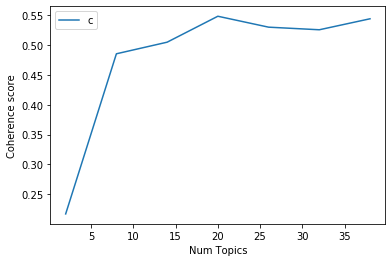

In [156]:
#Plotting the coherence for LDAmallet model for differen k values
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [157]:
#best LDA model at topic number = 20 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=texts_dict)

In [158]:
pprint(ldamallet.show_topics(formatted=False))

[(10,
  [('button', 0.047977959544915995),
   ('hand', 0.046992991021084035),
   ('hold', 0.044766105662855264),
   ('trash', 0.043138766362611165),
   ('open', 0.030419824989650693),
   ('feature', 0.02538078312135098),
   ('lock', 0.0218977060225829),
   ('place', 0.02021326709776883),
   ('turn', 0.01795783192725508),
   ('close', 0.017786533053545172)]),
 (14,
  [('recommend', 0.07153118554868075),
   ('review', 0.03637010169973686),
   ('highly', 0.03506151767299623),
   ('amazon', 0.033781381125097786),
   ('highly_recommend', 0.025616954697389945),
   ('give', 0.02408079083991181),
   ('read', 0.02336960386885712),
   ('buying', 0.021392504089325085),
   ('order', 0.0190598108242657),
   ('decided', 0.01731029087547116)]),
 (1,
  [('sheet', 0.13642859105773722),
   ('soft', 0.10328670752150375),
   ('nice', 0.07601198164280415),
   ('feel', 0.058053257852647776),
   ('towel', 0.05031740361098134),
   ('wash', 0.03579378383577455),
   ('super', 0.03565637967517656),
   ('thick', 

In [159]:
#Coeherenc coefficient calculation for Mallet LDA
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=texts_dict, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5370146906257448


In [161]:
ldamallet.save('ldamallet.lda')